# SSD (Single Shot MultiBox Detector model for object detection**)
not: This notebook requires a GPU runtime to run.

- | 
![alt](https://pytorch.org/assets/images/ssd_diagram.png)

In [1]:
import torch 
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [2]:
%%bash
pip install numpy scipy scikit-image matplotlib
pip install opencv-python

For convenient and comprehensive formatting of input and output of the model, load a set of utility methods. <br>
Utils coming with torch hub.

In [3]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


# Now, prepare the loaded model for inference

In [4]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

Prepare input images for object detection.
(Example links below correspond to first few test images from the COCO dataset, but you can also specify paths to your local images here)

In [0]:
# uris = [
#     'http://images.cocodataset.org/val2017/000000397133.jpg',
#     'http://images.cocodataset.org/val2017/000000037777.jpg',
#     'http://images.cocodataset.org/val2017/000000252219.jpg'
# ]
uris = [
    'https://raw.githubusercontent.com/develooper1994/SingleShotMultiboxDetector_demo/master/asset/desired_input.png'
]

Format the images to comply with the network input and convert them to tensor.

In [0]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

Run the SSD network to perform object detection.

In [0]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

By default, raw output from SSD network per input image contains
8732 boxes with localization and class probability distribution.
Let's filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [0]:
threshold = 0.5
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, threshold) for results in results_per_input]

The model was trained on COCO dataset, which we need to access in order to translate class IDs into object names.
For the first time, downloading annotations may take a while.

In [0]:
classes_to_labels = utils.get_coco_object_dictionary()

Finally, let's visualize our detections

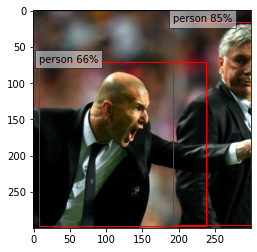

In [10]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, !! denormalized !! image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig('detected_ssd.png')
plt.show()